<a href="https://colab.research.google.com/github/NaouresBzeouich/projet_traitement_d-image/blob/main/3D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Processing of Multispectral Data Project - A Study on Indian Pines And Pavia University

## Groupe:
- Naoures Bzeouich

- Omar Mejdi

- Mohamed Aziz Balti

- Ghassen Cherif

- Ahmed Silini

## installaton du données :

In [11]:

!pip install --quiet gdown

Indian_pines_corrected_id = '1qKiIK-ZZsb8-6LXJisVu-OGb5sqqJ9nK'
!gdown https://drive.google.com/uc?id={Indian_pines_corrected_id}

Indian_pines_id = '1U1GgOfIheD8ZjkY87x7MqV2ow4kw2kIi'
!gdown https://drive.google.com/uc?id={Indian_pines_id}

Indian_pines_gt_id= '1o2vUv8gs3z7k11SE7hjPiL1EoldFrzLD'
!gdown https://drive.google.com/uc?id={Indian_pines_gt_id}

pavia_U_gt_id = '1MHPc5ztgljCHhRh6ZBF2Tui85LaC0-NL'
!gdown https://drive.google.com/uc?id={pavia_U_gt_id}

pavia_U_id= '159g6cecio9v0tDRPIahcYvJVHaMaOBBY'
!gdown https://drive.google.com/uc?id={pavia_U_id}

Downloading...
From (original): https://drive.google.com/uc?id=1qKiIK-ZZsb8-6LXJisVu-OGb5sqqJ9nK
From (redirected): https://drive.google.com/uc?id=1qKiIK-ZZsb8-6LXJisVu-OGb5sqqJ9nK&confirm=t&uuid=6a36f4bf-39b9-4e92-b3e1-3b7a3678e95c
To: /content/Indian_pines_corrected.mat
100% 5.95M/5.95M [00:00<00:00, 28.7MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1U1GgOfIheD8ZjkY87x7MqV2ow4kw2kIi
From (redirected): https://drive.google.com/uc?id=1U1GgOfIheD8ZjkY87x7MqV2ow4kw2kIi&confirm=t&uuid=89e262da-eac0-463c-a4e3-6710f82a73ed
To: /content/Indian_pines.mat
100% 6.30M/6.30M [00:00<00:00, 39.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1o2vUv8gs3z7k11SE7hjPiL1EoldFrzLD
From (redirected): https://drive.google.com/uc?id=1o2vUv8gs3z7k11SE7hjPiL1EoldFrzLD&confirm=t&uuid=9695271e-3452-4456-bf01-f842fae19521
To: /content/Indian_pines_gt.mat
100% 1.12k/1.12k [00:00<00:00, 6.56MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1MHPc5ztgljC

# 3. classification des images par un modèle de deep learning

## 3.2 model CNN pour l’image Indian Pines :

L'architecture HybridSN utilisée dans cette implémentation se compose des couches suivantes :

 - Convolution 3D  

- Batch Normalization 3D

- Reshape (Réorganisation) :La sortie du bloc 3D est aplatée et réorganisée pour devenir compatible avec les couches 2D.

- Convolution 2D

- Batch Normalization 2D

- Couche Fully Connected (FC)

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import scipy.io as sio
import os
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
# Define a simpler and more proven 3D-CNN architecture for hyperspectral imaging
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F



from sklearn.metrics import accuracy_score, f1_score
import torch
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

In [13]:
class HybridSN(nn.Module):
    def __init__(self, in_channels, patch_size, n_classes):
        super(HybridSN, self).__init__()

        self.patch_size = patch_size

        # 3D Convolution layer
        self.conv3d_1 = nn.Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.bn3d_1 = nn.BatchNorm3d(8)

        # Determine spatial dimensions after 3D operations
        dummy_input = torch.zeros(1, 1, in_channels, patch_size, patch_size)
        x = F.relu(self.bn3d_1(self.conv3d_1(dummy_input)))

        # Reshape for 2D convolution (N,C,D,H,W) -> (N,C*D,H,W)
        spatial_dim = patch_size
        n_dim = x.size(1) * x.size(2)  # Channels * Depth
        x = x.view(x.size(0), n_dim, spatial_dim, spatial_dim)

        # 2D Convolution layer
        self.conv2d_1 = nn.Conv2d(n_dim, 64, kernel_size=3, stride=1, padding=1)
        self.bn2d_1 = nn.BatchNorm2d(64)

        # Global average pooling
        x = F.relu(self.bn2d_1(self.conv2d_1(x)))
        x = F.adaptive_avg_pool2d(x, (1, 1))
        fc_size = x.view(x.size(0), -1).shape[1]

        # Fully connected layer
        self.fc1 = nn.Linear(fc_size, n_classes)

        print(f"Model initialized with FC input size: {fc_size}")

    def forward(self, x):
        # 3D Convolution path
        x = F.relu(self.bn3d_1(self.conv3d_1(x)))

        # Reshape for 2D convolution (N,C,D,H,W) -> (N,C*D,H,W)
        x = x.view(x.size(0), -1, x.size(3), x.size(4))

        # 2D Convolution path
        x = F.relu(self.bn2d_1(self.conv2d_1(x)))

        # Global average pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)

        # Fully connected path
        x = self.fc1(x)

        return x


In [14]:

# Custom Dataset for Indian Pines with data augmentation
class IndianPinesDataset(Dataset):
    def __init__(self, data, labels, patch_size=11, transforms=None, use_augmentation=False):
        self.data = data
        self.labels = labels
        self.patch_size = patch_size
        self.transforms = transforms
        self.use_augmentation = use_augmentation

        # Dimensions
        self.bands, self.height, self.width = data.shape

        # Create valid indices (excluding boundary pixels)
        self.valid_indices = []
        pad = patch_size // 2
        for i in range(pad, self.height - pad):
            for j in range(pad, self.width - pad):
                  self.valid_indices.append((i, j))

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        # Get center pixel coordinates
        i, j = self.valid_indices[idx]
        pad = self.patch_size // 2

        # Extract patch
        patch = self.data[:, i-pad:i+pad+1, j-pad:j+pad+1].copy()

        # Get label
        label = self.labels[i, j]

        # Apply data augmentation
        if self.use_augmentation and np.random.random() > 0.5:
            # Random flip
            if np.random.random() > 0.5:
                patch = np.flip(patch, axis=1).copy()
            if np.random.random() > 0.5:
                patch = np.flip(patch, axis=2).copy()

            # Random rotation (90, 180, 270 degrees)
            k = np.random.randint(1, 4)
            patch = np.rot90(patch, k=k, axes=(1, 2)).copy()

            # Small random noise
            if np.random.random() > 0.7:
                noise = np.random.normal(0, 0.01, patch.shape)
                patch = patch + noise

        # Convert to tensor
        patch = torch.FloatTensor(patch).unsqueeze(0)  # Add channel dimension for 3D convolution

        if self.transforms:
            patch = self.transforms(patch)

        return patch, label

In [15]:
# Function to load and preprocess the data
def load_indian_pines_data(data_path='Indian_pines.mat', gt_path='Indian_pines_gt.mat'):
    # Load data
    data = sio.loadmat(data_path)['indian_pines']
    gt = sio.loadmat(gt_path)['indian_pines_gt']

    # Normalize data using MinMaxScaler (better for preserving spatial info)
    scaler = MinMaxScaler()
    h, w, b = data.shape
    data_reshaped = data.reshape((h*w, b))
    data_normalized = scaler.fit_transform(data_reshaped)
    data = data_normalized.reshape((h, w, b))

    # Transpose to bands-first format (bands, height, width)
    data = np.transpose(data, (2, 0, 1))

    return data, gt


In [16]:
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=100):
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_f1_scores = []

    best_val_acc = 0.0
    best_val_f1 = 0.0
    best_model_state = None


    # Early stopping
    patience = 15
    counter = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0

        # Use tqdm for progress bar
        loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')

        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            # Update progress bar
            loop.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Validation (using the same data as training)
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_true = []

        with torch.no_grad():
            for inputs, labels in train_loader:  # Using the same train_loader for validation
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        val_epoch_loss = val_loss / len(train_loader.dataset)
        val_losses.append(val_epoch_loss)

        val_acc = accuracy_score(val_true, val_preds)
        val_accuracies.append(val_acc)

        # Calculate F1 score for more comprehensive evaluation
        val_f1 = f1_score(val_true, val_preds, average='weighted')
        val_f1_scores.append(val_f1)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, '
              f'Val Loss: {val_epoch_loss:.4f}, '
              f'Val Acc: {val_acc:.4f}, '
              f'Val F1: {val_f1:.4f}')

        # Save best model state (in memory)
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            counter = 0
            print(f"New best model saved with F1 Score: {val_f1:.4f}")
        else:
            counter += 1

        # Early stopping
        if counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load best model state back into the model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with F1 Score: {best_val_f1:.4f}")

    # Plot training curves
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(val_f1_scores, label='Val F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'training_curves_hybridsn_patch{model.patch_size}.png')

    print(f"Training complete. Best validation accuracy: {best_val_acc:.4f}, Best F1 Score: {best_val_f1:.4f}")

    return model, train_losses

In [17]:

# Function to predict on the entire image with CRF post-processing
def predict_image(model, data, patch_size, num_classes, device):
    model.eval()

    # Get dimensions
    bands, height, width = data.shape
    pad = patch_size // 2

    # Initialize prediction map
    pred_map = np.zeros((height, width))

    # Pad the data
    padded_data = np.pad(data, ((0, 0), (pad, pad), (pad, pad)), mode='reflect')

    # Process in batches for efficiency
    batch_size = 32  # Increased batch size for faster prediction
    coords = [(i, j) for i in range(height) for j in range(width)]
    num_batches = (len(coords) + batch_size - 1) // batch_size

    # Store class probabilities for all pixels
    prob_map = np.zeros((height, width, num_classes))

    with torch.no_grad():
        for batch_idx in tqdm(range(num_batches), desc="Predicting"):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, len(coords))
            batch_coords = coords[start_idx:end_idx]

            batch_patches = []
            for i, j in batch_coords:
                # Extract patch
                patch = padded_data[:, i:i+patch_size, j:j+patch_size]
                batch_patches.append(patch)

            # Stack patches and convert to tensor
            batch_patches = torch.FloatTensor(np.array(batch_patches)).unsqueeze(1)  # Add channel dimension

            # Predict
            outputs = model(batch_patches.to(device))
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            _, preds = torch.max(outputs, 1)

            # Store predictions and probabilities
            for idx, (i, j) in enumerate(batch_coords):
                pred_map[i, j] = preds[idx].item() + 1  # Convert back to 1-based indexing
                prob_map[i, j] = probs[idx]

    # Try to use CRF for post-processing if pydensecrf is available
    try:
        import pydensecrf.densecrf as dcrf
        from pydensecrf.utils import unary_from_softmax

        print("Applying CRF post-processing...")

        # Create CRF model
        d = dcrf.DenseCRF2D(width, height, num_classes)

        # Reshape probability map for CRF
        U = unary_from_softmax(np.transpose(prob_map, (2, 0, 1)))
        d.setUnaryEnergy(U)

        # Add pairwise potentials
        d.addPairwiseGaussian(sxy=3, compat=3)
        d.addPairwiseBilateral(sxy=80, srgb=13, rgbim=np.transpose(data[:3], (1, 2, 0)), compat=10)

        # Perform inference
        Q = d.inference(5)
        pred_map_crf = np.argmax(np.array(Q).reshape((num_classes, height, width)), axis=0) + 1

        print("CRF post-processing complete.")

    except ImportError:
        print("pydensecrf not available, using median filter instead.")
        # Apply median filter as fallback
        from scipy import ndimage
        pred_map_crf = ndimage.median_filter(pred_map, size=3)

    return pred_map, pred_map_crf, prob_map


In [18]:
# Main execution function
def run_indian_pines_segmentation(patch_size=11):
    # Check if patch size is even, and if so, make it odd
    if patch_size % 2 == 0:
        print(f"Warning: Patch size {patch_size} is even. Using {patch_size+1} instead.")
        patch_size = patch_size + 1

    # Check for GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # Load data
    print("Loading and preprocessing data...")
    data, gt = load_indian_pines_data()

    # Dataset parameters
    num_classes = 17  # Indian Pines has 16 classes
    batch_size = 32

    print(f"Using patch size: {patch_size}")

    # Create dataset with data augmentation for training
    train_dataset = IndianPinesDataset(data, gt, patch_size=patch_size, use_augmentation=False)

    # Use all data for training (no validation split)
    print("Using all data for training")

    # Create data loader for training
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    # For debugging purposes, let's check the shape of a sample
    sample_input, _ = train_dataset[0]
    print(f"Sample input shape: {sample_input.shape}")
    #########################################################

    ###################################################
    # Initialize model
    print("Creating HybridSN model")
    model = HybridSN(
        in_channels=data.shape[0],
        patch_size=patch_size,
        n_classes=num_classes
    ).to(device)

    # Print model summary
    print(model)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")

    # Assuming train_dataset is already defined, you can update the class weight calculation as follows:
    labels = [train_dataset[i][1] for i in range(len(train_dataset))]

    # Convert labels to a numpy array before computing class weights
    labels = np.array(labels)

    # Compute class weights using sklearn's compute_class_weight
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)

    # Convert class_weights to a PyTorch tensor
    class_weights = torch.tensor(class_weights, dtype=torch.float32)

    # Ensure that the class_weights tensor is on the same device as your model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    class_weights = class_weights.to(device)

    # Define the criterion with the class weights
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # Optimizer with weight decay
    optimizer = optim.Adam(model.parameters(), lr=0.0006, weight_decay=1e-4)

    # Train the model
    print("Training the model...")
    trained_model, train_losses = train_model(
        model, train_loader, criterion, optimizer, device, num_epochs=25
    )

    # Use the trained model directly for prediction
    print("Generating segmentation map using the trained model...")
    pred_map, pred_map_crf, prob_map = predict_image(trained_model, data, patch_size, num_classes, device)

    # Save the prediction maps
    np.save(f'indian_pines_prediction_map_hybridsn_patch{patch_size}.npy', pred_map)
    np.save(f'indian_pines_prediction_map_crf_patch{patch_size}.npy', pred_map_crf)

    # Visualize results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(gt)
    plt.title('Ground Truth')
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.imshow(pred_map)
    plt.title(f'Raw Prediction')
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.imshow(pred_map_crf)
    plt.title(f'Post-processed Prediction')
    plt.colorbar()

    plt.tight_layout()
    plt.savefig(f'indian_pines_segmentation_results_hybridsn_patch{patch_size}.png')
    plt.show()

    print("Segmentation complete!")

    return trained_model, pred_map, pred_map_crf

Using device: cuda
Loading and preprocessing data...
Using patch size: 5
Using all data for training
Sample input shape: torch.Size([1, 220, 5, 5])
Creating HybridSN model
Model initialized with FC input size: 64
HybridSN(
  (conv3d_1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn3d_1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d_1): Conv2d(1760, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2d_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=64, out_features=17, bias=True)
)
Total parameters: 1,015,297


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training the model...


Epoch 1/25:   0%|          | 0/622 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/25: 100%|██████████| 622/622 [00:12<00:00, 47.88it/s, loss=0.598]


Epoch 1/25, Train Loss: 1.0948, Val Loss: 0.5188, Val Acc: 0.7462, Val F1: 0.7570
New best model saved with F1 Score: 0.7570


Epoch 2/25:   0%|          | 0/622 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 2/25: 100%|██████████| 622/622 [00:06<00:00, 99.56it/s, loss=0.444] 


Epoch 2/25, Train Loss: 0.3358, Val Loss: 0.2515, Val Acc: 0.7554, Val F1: 0.7598
New best model saved with F1 Score: 0.7598


Epoch 3/25:   0%|          | 0/622 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 3/25: 100%|██████████| 622/622 [00:06<00:00, 102.40it/s, loss=0.0364]


Epoch 3/25, Train Loss: 0.1767, Val Loss: 0.1602, Val Acc: 0.8922, Val F1: 0.8953
New best model saved with F1 Score: 0.8953


Epoch 4/25:   0%|          | 0/622 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 4/25: 100%|██████████| 622/622 [00:05<00:00, 111.17it/s, loss=0.0999]


Epoch 4/25, Train Loss: 0.1224, Val Loss: 0.0922, Val Acc: 0.9046, Val F1: 0.9051
New best model saved with F1 Score: 0.9051


Epoch 5/25:   0%|          | 0/622 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 5/25: 100%|██████████| 622/622 [00:06<00:00, 97.55it/s, loss=0.284] 


Epoch 5/25, Train Loss: 0.0999, Val Loss: 0.2541, Val Acc: 0.6460, Val F1: 0.6389


Epoch 6/25:   0%|          | 0/622 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 6/25: 100%|██████████| 622/622 [00:06<00:00, 100.44it/s, loss=0.125]


Epoch 6/25, Train Loss: 0.0876, Val Loss: 0.0846, Val Acc: 0.9191, Val F1: 0.9211
New best model saved with F1 Score: 0.9211


Epoch 7/25:   0%|          | 0/622 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 7/25: 100%|██████████| 622/622 [00:05<00:00, 111.85it/s, loss=0.156]


Epoch 7/25, Train Loss: 0.0728, Val Loss: 0.0475, Val Acc: 0.9489, Val F1: 0.9492
New best model saved with F1 Score: 0.9492


Epoch 8/25:   0%|          | 0/622 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 8/25: 100%|██████████| 622/622 [00:06<00:00, 96.09it/s, loss=0.0386]


Epoch 8/25, Train Loss: 0.0693, Val Loss: 0.1213, Val Acc: 0.9305, Val F1: 0.9332


Epoch 9/25:   0%|          | 0/622 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 9/25: 100%|██████████| 622/622 [00:06<00:00, 99.31it/s, loss=0.0439] 


Epoch 9/25, Train Loss: 0.0599, Val Loss: 0.0534, Val Acc: 0.9623, Val F1: 0.9626
New best model saved with F1 Score: 0.9626


Epoch 10/25:   0%|          | 0/622 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 10/25: 100%|██████████| 622/622 [00:05<00:00, 109.91it/s, loss=0.0207]


Epoch 10/25, Train Loss: 0.0556, Val Loss: 0.1236, Val Acc: 0.9036, Val F1: 0.9166


Epoch 11/25:   0%|          | 0/622 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 11/25: 100%|██████████| 622/622 [00:05<00:00, 110.45it/s, loss=0.0462]


Epoch 11/25, Train Loss: 0.0551, Val Loss: 0.0452, Val Acc: 0.9410, Val F1: 0.9419


Epoch 12/25:   0%|          | 0/622 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 12/25: 100%|██████████| 622/622 [00:06<00:00, 99.39it/s, loss=0.082] 


Epoch 12/25, Train Loss: 0.0546, Val Loss: 0.0438, Val Acc: 0.9165, Val F1: 0.9182


Epoch 13/25:   0%|          | 0/622 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 13/25: 100%|██████████| 622/622 [00:05<00:00, 110.68it/s, loss=0.0486]


Epoch 13/25, Train Loss: 0.0511, Val Loss: 0.0858, Val Acc: 0.9478, Val F1: 0.9468


Epoch 14/25:   0%|          | 0/622 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 14/25: 100%|██████████| 622/622 [00:05<00:00, 110.45it/s, loss=0.0531]


Epoch 14/25, Train Loss: 0.0477, Val Loss: 0.0436, Val Acc: 0.9152, Val F1: 0.9156


Epoch 15/25:   0%|          | 0/622 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 15/25: 100%|██████████| 622/622 [00:06<00:00, 99.72it/s, loss=0.0521] 


Epoch 15/25, Train Loss: 0.0464, Val Loss: 0.0730, Val Acc: 0.9663, Val F1: 0.9660
New best model saved with F1 Score: 0.9660


Epoch 16/25:   0%|          | 0/622 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 16/25: 100%|██████████| 622/622 [00:05<00:00, 107.90it/s, loss=0.041]


Epoch 16/25, Train Loss: 0.0430, Val Loss: 0.0858, Val Acc: 0.9710, Val F1: 0.9710
New best model saved with F1 Score: 0.9710


Epoch 17/25:   0%|          | 0/622 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 17/25: 100%|██████████| 622/622 [00:05<00:00, 108.74it/s, loss=0.147]


Epoch 17/25, Train Loss: 0.0444, Val Loss: 0.0600, Val Acc: 0.9559, Val F1: 0.9568


Epoch 18/25:   0%|          | 0/622 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 18/25: 100%|██████████| 622/622 [00:06<00:00, 99.42it/s, loss=0.00707] 


Epoch 18/25, Train Loss: 0.0394, Val Loss: 0.0277, Val Acc: 0.9722, Val F1: 0.9724
New best model saved with F1 Score: 0.9724


Epoch 19/25:   0%|          | 0/622 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 19/25: 100%|██████████| 622/622 [00:05<00:00, 103.81it/s, loss=0.258]


Epoch 19/25, Train Loss: 0.0368, Val Loss: 0.0679, Val Acc: 0.9720, Val F1: 0.9727
New best model saved with F1 Score: 0.9727


Epoch 20/25:   0%|          | 0/622 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 20/25: 100%|██████████| 622/622 [00:05<00:00, 111.69it/s, loss=0.335]


Epoch 20/25, Train Loss: 0.0369, Val Loss: 0.0520, Val Acc: 0.9540, Val F1: 0.9542


Epoch 21/25:   0%|          | 0/622 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 21/25: 100%|██████████| 622/622 [00:06<00:00, 97.66it/s, loss=0.0411] 


Epoch 21/25, Train Loss: 0.0365, Val Loss: 0.0401, Val Acc: 0.9140, Val F1: 0.9139


Epoch 22/25:   0%|          | 0/622 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 22/25: 100%|██████████| 622/622 [00:06<00:00, 103.62it/s, loss=0.0606]


Epoch 22/25, Train Loss: 0.0341, Val Loss: 0.3621, Val Acc: 0.9222, Val F1: 0.9169


Epoch 23/25:   0%|          | 0/622 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 23/25: 100%|██████████| 622/622 [00:05<00:00, 110.90it/s, loss=0.0286]


Epoch 23/25, Train Loss: 0.0386, Val Loss: 0.0223, Val Acc: 0.9589, Val F1: 0.9593


Epoch 24/25:   0%|          | 0/622 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 24/25: 100%|██████████| 622/622 [00:06<00:00, 98.03it/s, loss=0.29] 


Epoch 24/25, Train Loss: 0.0328, Val Loss: 0.1653, Val Acc: 0.9300, Val F1: 0.9271


Epoch 25/25:   0%|          | 0/622 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 25/25: 100%|██████████| 622/622 [00:06<00:00, 100.27it/s, loss=0.0139]


Epoch 25/25, Train Loss: 0.0332, Val Loss: 0.0234, Val Acc: 0.9766, Val F1: 0.9768
New best model saved with F1 Score: 0.9768
Loaded best model with F1 Score: 0.9768
Training complete. Best validation accuracy: 0.9766, Best F1 Score: 0.9768
Generating segmentation map using the trained model...


Predicting: 100%|██████████| 658/658 [00:01<00:00, 400.07it/s]


pydensecrf not available, using median filter instead.


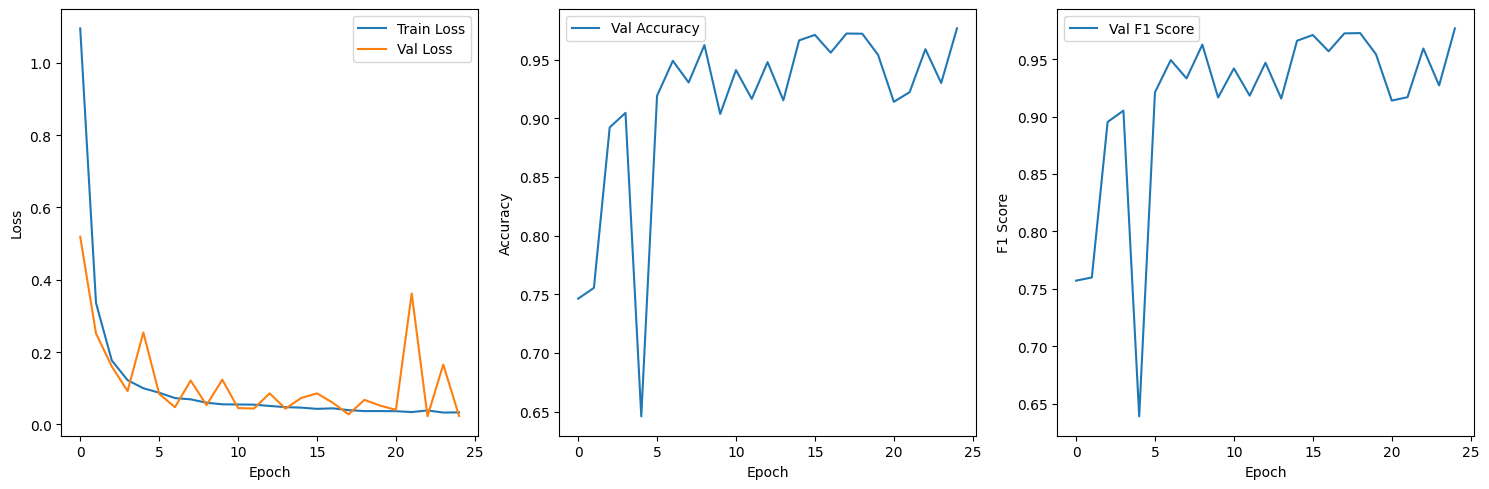

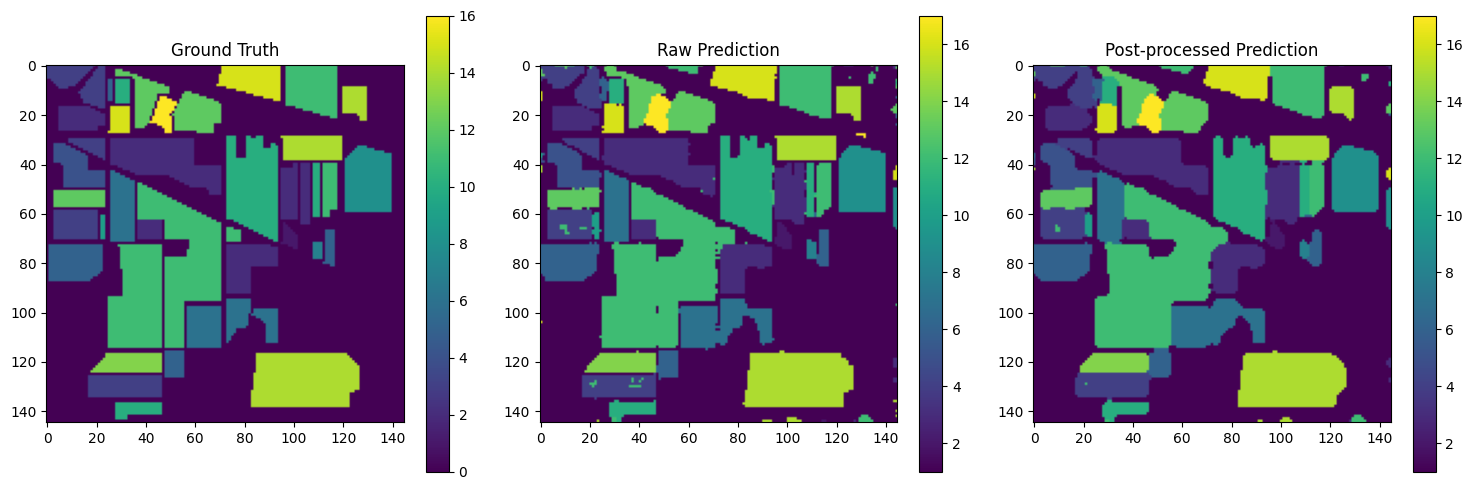

Segmentation complete!


(HybridSN(
   (conv3d_1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
   (bn3d_1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (conv2d_1): Conv2d(1760, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (bn2d_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (fc1): Linear(in_features=64, out_features=17, bias=True)
 ),
 array([[ 4.,  4.,  4., ...,  1.,  3.,  3.],
        [ 4.,  4.,  4., ...,  1.,  3., 13.],
        [13.,  4.,  4., ...,  1.,  1.,  1.],
        ...,
        [ 1.,  1.,  1., ...,  1.,  1., 15.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]]),
 array([[4., 4., 4., ..., 1., 3., 3.],
        [4., 4., 4., ..., 1., 1., 3.],
        [4., 4., 4., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]))

In [20]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

patch_size =  5 # Larger patch size for better spatial context
run_indian_pines_segmentation(patch_size)

In [21]:
data, gt = load_indian_pines_data()

In [22]:
# Disable truncation so the full matrix is shown
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

print(gt)

[[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  0  3  3  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15  0  0 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  0  0  3  3  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15  0  0 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  0  0  3  3  3  3  0  0  0  0 12 12 12  0  0  0  0  0  0  0  0  0  0